In [24]:
#read data
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

 
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from scipy.stats import chisquare

In [16]:
df = pd.read_csv("/Users/user/Documents/github/Text-Analysis---Ontolligent-Corpus/data/corpus.csv", sep = "|")

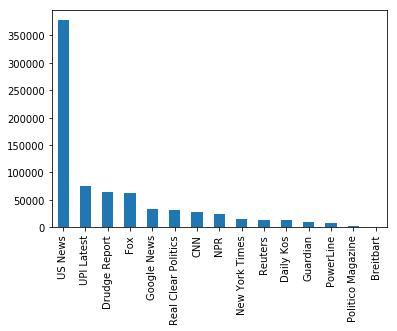

In [17]:
#what is distribution for sources
df.doc_source.value_counts().plot('bar')

In [18]:
#drop NaNs
df = df.dropna()
df.shape

(722410, 6)

In [19]:
# assigning labels of left leaning (L) and right leaning (R)
#reducing cardinality of labels to 3
# assigning labels of left leaning (L) and right leaning (R)
list_of_sources = ['US News', 'UPI Latest','Drudge Report','Fox',
'Google News',
'Real Clear Politics',
'CNN',
'NPR',
'New York Times',
'Reuters',
'Daily Kos',
'Guardian',
'PowerLine',
'Politico Magazine',
'Breitbart']

list_of_labels = ['left-center',
'center',
'right',
'right',
'left',
'right-center',
'left',
'left-center',
'left-center',
'center',
'left',
'left-center',
'right',
'center',
'right']

dictionary = dict(zip(list_of_sources, list_of_labels))
df['label']= df['doc_source'].map(dictionary)





list_of_sources = ['left', 'left-center','center','right-center',
'right']

list_of_labels = ['left', 'left','center','right',
'right']


dictionary = dict(zip(list_of_sources, list_of_labels))
df['label_final']= df['label'].map(dictionary)

In [20]:
df.head()

,doc_id,doc_source,doc_title,doc_content,doc_date,doc_url,label,label_final
0,39,Google News,"50 Years on, Finding Profit in 'Truth' on JFK ...","Washington Post50 Years on, Finding Profit in ...",11/03/2013,http://news.google.com/news/url?sa=t&fd=R&usg=...,left,left
1,38,Google News,"Nearly 10 years later, families and officials ...","Washington PostNearly 10 years later, families...",11/03/2013,http://news.google.com/news/url?sa=t&fd=R&usg=...,left,left
2,37,Google News,"Cuccinelli, running hard, has been hobbled in ...","Washington PostCuccinelli, running hard, has b...",11/03/2013,http://news.google.com/news/url?sa=t&fd=R&usg=...,left,left
3,36,Google News,Chuck Schumer endorses Hillary Clinton for Pre...,New York Daily NewsChuck Schumer endorses Hill...,11/03/2013,http://news.google.com/news/url?sa=t&fd=R&usg=...,left,left
4,35,Google News,Sec. Kerry issues apparent warning to Iran - C...,Ahram OnlineSec. Kerry issues apparent warning...,11/03/2013,http://news.google.com/news/url?sa=t&fd=R&usg=...,left,left


In [21]:
#balancing classes by downsampling "left" news 
left = df[df["label_final"] == "left"]
other = df[df["label_final"] != "left"]



In [22]:
len(left)

494189

In [25]:
#code to ensure that the distribution of news sources is preserved while downsampling
div = []
for i in range(500):
    sample = left.sample(136305, random_state=i)
    p = chisquare(sample["doc_source"].value_counts(normalize = True).tolist(), f_exp=left["doc_source"].value_counts(normalize = True).tolist())[0]
    div.append(p)
    if len(div) == 0:
        continue
    if p < min(div):
         break
lowest_div = min(div)



In [26]:

#code to ensure that the distribution of news sources is preserved while downsampling
for i in range(500):
    sample = left.sample(136305, random_state=i)
    p = chisquare(sample["doc_source"].value_counts(normalize = True).tolist(), f_exp=left["doc_source"].value_counts(normalize = True).tolist())[0]
    if p <= lowest_div:
        break

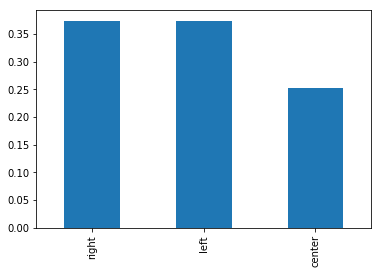

In [41]:
#df = pd.concat([sample,other], axis = 0)

#distribution of different labels

df.label_final.value_counts(normalize = True).plot('bar')

In [42]:
#chcking for null values after labeling
df[df["label_final"].isnull()].shape

(0, 8)

In [43]:
df.label.value_counts()
df.groupby(["doc_source","label"]).size()

doc_source           label       
Breitbart            right              146
CNN                  left              7330
Daily Kos            left              3412
Drudge Report        right            64733
Fox                  right            37356
Google News          left              9199
Guardian             left-center       2629
NPR                  left-center       5469
New York Times       left-center       4106
Politico Magazine    center            2737
PowerLine            right             7334
Real Clear Politics  right-center     26736
Reuters              center           13348
UPI Latest           center           75831
US News              left-center     104160
dtype: int64

In [44]:
df = df.reindex(np.arange(df.index.min(), df.index.max() + 1))

In [45]:
#imporiting all libraries
# Run in python console
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'say', 'not', 'go', 'do'])

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
# Convert to list
data = df.doc_content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[1837][0:2000])

'nan'


In [47]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['washington', 'postcuccinelli', 'running', 'hard', 'has', 'been', 'hobbled', 'in', 'raceroanoke', 'timesthe', 'big', 'money', 'donors', 'that', 'helped', 'moderate', 'bob', 'mcdonnell', 'have', 'not', 'turned', 'out', 'for', 'him', 'related', 'coverage', 'gubernatorial', 'election', 'puts', 'virginia', 'at', 'crucial', 'crossroads', 'november', 'cuccinelli', 'mcauliffe', 'try', 'to', 'fire', 'up', 'their', 'bases', 'november', 'obama', 'heads', 'to', 'virginia', 'to', 'campaign', 'for', 'analyst', 'talks', 'about', 'importance', 'of', 'women', 'voterswhsvrace', 'for', 'virginia', 'governor', 'could', 'hinge', 'on', 'womenwwlpatch', 'comall', 'news', 'articles']]


In [48]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Applications/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['washington', 'postcuccinelli', 'running', 'hard', 'has', 'been', 'hobbled', 'in', 'raceroanoke', 'timesthe', 'big', 'money', 'donors', 'that', 'helped', 'moderate', 'bob', 'mcdonnell', 'have', 'not', 'turned', 'out', 'for', 'him', 'related', 'coverage', 'gubernatorial', 'election', 'puts', 'virginia', 'at', 'crucial', 'crossroads', 'november', 'cuccinelli', 'mcauliffe', 'try', 'to', 'fire', 'up', 'their', 'bases', 'november', 'obama', 'heads', 'to', 'virginia', 'to', 'campaign', 'for', 'analyst', 'talks', 'about', 'importance', 'of', 'women', 'voterswhsvrace', 'for', 'virginia', 'governor', 'could', 'hinge', 'on', 'womenwwlpatch', 'comall_news_articles']


In [49]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [51]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['washington', 'postcuccinelli', 'run', 'hard', 'hobble', 'raceroanoke', 'big', 'money', 'donor', 'help', 'moderate', 'bob', 'mcdonnell', 'turn', 'related', 'coverage', 'gubernatorial', 'election', 'put', 'virginia', 'crucial', 'crossroad', 'november', 'cuccinelli', 'mcauliffe', 'try', 'fire', 'basis', 'november', 'obama', 'head', 'virginia', 'campaign', 'analyst', 'talk', 'importance', 'woman', 'voterswhsvrace', 'virginia', 'governor', 'could', 'hinge', 'womenwwlpatch', 'comall_news', 'article']]


In [52]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 3), (38, 1), (39, 1), (40, 1), (41, 1)]]


In [53]:
lda_model# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [57]:
lda_model.save('lda.model')

In [54]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"new" + 0.008*"news" + 0.007*"state" + 0.007*"year" + 0.006*"say" + '
  '0.006*"time" + 0.006*"people" + 0.006*"make" + 0.005*"get" + 0.004*"take"'),
 (1,
  '0.025*"man" + 0.020*"year" + 0.020*"police" + 0.016*"charge" + 0.015*"kill" '
  '+ 0.013*"authority" + 0.012*"old" + 0.011*"woman" + 0.011*"say" + '
  '0.009*"arrest"'),
 (2,
  '0.033*"trump" + 0.030*"president" + 0.019*"say" + 0.014*"donald" + '
  '0.013*"house" + 0.013*"reuter" + 0.011*"former" + 0.009*"democratic" + '
  '0.009*"democrat" + 0.008*"thursday"'),
 (3,
  '0.308*"nan" + 0.008*"game" + 0.007*"star" + 0.006*"team" + 0.005*"season" + '
  '0.005*"announce" + 0.004*"win" + 0.004*"first" + 0.004*"final" + '
  '0.004*"home"')]


In [55]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.60032159987445

Coherence Score:  0.6130458213450425


In [74]:
lda_model

In [61]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Applications/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.142290  0.082430       1        1  46.526085
2     -0.107714  0.249206       2        1  22.000742
1     -0.126789 -0.324734       3        1  15.951638
3      0.376793 -0.006902       4        1  15.521538, topic_info=      Category           Freq            Term          Total  loglift  logprob
82     Default  388565.000000             nan  388565.000000  30.0000  30.0000
2608   Default   58349.000000           trump   58349.000000  29.0000  29.0000
70     Default   53191.000000       president   53191.000000  28.0000  28.0000
149    Default   31944.000000             man   31944.000000  27.0000  27.0000
352    Default   50817.000000            year   50817.000000  26.0000  26.0000
2496   Default   25346.000000          police   25346.000000  25.0000  25.0000
369    Default   20907.000000          charge   20907.000000  24.0000  24.0000
5214   Default   24979.000000          donald   24979.000000  23.0000  23.0000
145    Default   19790.000000            kill   19790.000000  22.0000  22.0000
105    Default   23439.000000           house   23439.000000  21.0000  21.0000
263    Default   22875.000000          reuter   22875.000000  20.0000  20.0000
121    Default   71540.000000             say   71540.000000  19.0000  19.0000
133    Default   16834.000000       authority   16834.000000  18.0000  18.0000
68     Default   16512.000000             old   16512.000000  17.0000  17.0000
40     Default   19127.000000           woman   19127.000000  16.0000  16.0000
1724   Default   16554.000000      democratic   16554.000000  15.0000  15.0000
65     Default   55407.000000             new   55407.000000  14.0000  14.0000
209    Default   16089.000000        democrat   16089.000000  13.0000  13.0000
713    Default   21861.000000          former   21861.000000  12.0000  12.0000
2377   Default   12239.000000          arrest   12239.000000  11.0000  11.0000
122    Default   12200.000000          second   12200.000000  10.0000  10.0000
13     Default   13745.000000        election   13745.000000   9.0000   9.0000
140    Default   11206.000000           death   11206.000000   8.0000   8.0000
5      Default   13105.000000        campaign   13105.000000   7.0000   7.0000
665    Default   10755.000000           story   10755.000000   6.0000   6.0000
731    Default   12997.000000           white   12997.000000   5.0000   5.0000
153    Default   10560.000000         officer   10560.000000   4.0000   4.0000
1239   Default   13980.000000             die   13980.000000   3.0000   3.0000
2443   Default   12729.000000    presidential   12729.000000   2.0000   2.0000
39     Default   12416.000000      washington   12416.000000   1.0000   1.0000
...        ...            ...             ...            ...      ...      ...
864     Topic4    1878.743774          island    1879.724487   1.8624  -6.5088
3804    Topic4    1860.006958       tennessee    1861.003906   1.8624  -6.5188
3637    Topic4    1769.832642        kentucky    1770.789673   1.8624  -6.5685
1871    Topic4    1715.369751          rescue    1716.301514   1.8624  -6.5997
2369    Topic4    2095.772217  south_carolina    2097.147217   1.8623  -6.3994
2190    Topic4    2004.528564            ohio    2005.657227   1.8624  -6.4440
5365    Topic4    1927.702881          injury    1928.943481   1.8623  -6.4830
10864   Topic4    1845.180786         indiana    1846.338745   1.8623  -6.5268
674     Topic4    7656.491699            team    8276.139648   1.7851  -5.1038
3042    Topic4    4948.970703           final    5485.201172   1.7601  -5.5402
1767    Topic4    2573.234863           score    2665.084717   1.8279  -6.1942
630     Topic4    4480.756836            play    5462.165039   1.6649  -5.6396
43      Topic4    6688.095215        announce    9707.962891   1.4903  -5.2390
1779    Topic4    5272.739746             win    7153.869141   1.5578  -5.4768

In [62]:
para_topics = [lda_model[x] for x in corpus]

In [63]:
para_topics = np.array(para_topics)

In [70]:
topic_df = pd.DataFrame(para_topics)

In [72]:
topic_df.head()

,0,1,2
0,"[(0, 0.34463984), (1, 0.08631404), (2, 0.50630...","[(0, [0]), (1, [0, 2]), (2, [0]), (3, [0, 3]),...","[(0, [(0, 0.9997804)]), (1, [(0, 0.8942551), (..."
1,"[(0, 0.3381671), (1, 0.05498609), (2, 0.5869),...","[(33, [2, 0, 3]), (42, [2, 3]), (43, [2, 3]), ...","[(33, [(0, 0.40202126), (2, 1.5707555), (3, 0...."
2,"[(0, 0.24028614), (1, 0.093497135), (2, 0.1184...","[(82, [3])]","[(82, [(3, 1.0)])]"
3,"[(0, 0.24028614), (1, 0.093497135), (2, 0.1184...","[(82, [3])]","[(82, [(3, 1.0)])]"
4,"[(0, 0.3756923), (1, 0.06528475), (2, 0.520028...","[(28, [2, 0]), (30, [0, 2]), (39, [2]), (66, [...","[(28, [(0, 0.054247666), (2, 0.9457506)]), (30..."


In [79]:
df["topic0"] = 0
df["topic1"] = 0
df["topic2"] = 0
df["topic3"] = 0
printcounter = 0
for index,row in df.iterrows():
    if (printcounter == 1000000):
        print(printcounter)
        printcounter = 0
    try:
        mod_output = lda_model[corpus[index]][0]
    except IndexError:
        break
    for (topic,prob) in mod_output:
        df.loc[index,'topic' + str(topic)] = prob
    printcounter += 1
df.to_csv("/Users/user/Documents/github/Text-Analysis---Ontolligent-Corpus/data/corpus_topics.csv")

In [65]:
df["topic0"] = 0
df["topic1"] = 0
df["topic2"] = 0
df["topic3"] = 0
for index,row in df.iterrows():
#     print(index)
#     print(row)
    try:
        mod_output = lda_model[corpus[index]][0]
    except IndexError:
#         print(mod_output)
#         print(index)
        break
    for (topic,prob) in mod_output:
#         print(topic)
#         print(prob)
        df.loc[index,'topic' + str(topic)] = prob

In [66]:
df.head()

,doc_id,doc_source,doc_title,doc_content,doc_date,doc_url,label,label_final,topic0,topic1,topic2,topic3
2,37.0,Google News,"Cuccinelli, running hard, has been hobbled in ...","Washington PostCuccinelli, running hard, has b...",11/03/2013,http://news.google.com/news/url?sa=t&fd=R&usg=...,left,left,0.240286,0.093497,0.118454,0.547763
3,36.0,Google News,Chuck Schumer endorses Hillary Clinton for Pre...,New York Daily NewsChuck Schumer endorses Hill...,11/03/2013,http://news.google.com/news/url?sa=t&fd=R&usg=...,left,left,0.240286,0.093497,0.118454,0.547763
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.375696,0.065267,0.520043,0.038995
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.260153,0.590841,0.058296,0.090710
6,33.0,Google News,"ObamaCare architect defends plan, says preside...",Washington PostObamaCare architect defends pla...,11/03/2013,http://news.google.com/news/url?sa=t&fd=R&usg=...,left,left,0.240286,0.093497,0.118454,0.547763


In [68]:
df.groupby(["label_final"]).mean()

,doc_id,topic0,topic1,topic2,topic3
label_final,,,,,
center,369471.296575,0.382938,0.112885,0.174311,0.329816
left,388048.268295,0.295698,0.121843,0.150407,0.432003
right,393270.381901,0.347730,0.290793,0.175834,0.185477


In [71]:
topic_df.head()

,0,1,2
0,"[(0, 0.34463984), (1, 0.08631404), (2, 0.50630...","[(0, [0]), (1, [0, 2]), (2, [0]), (3, [0, 3]),...","[(0, [(0, 0.9997804)]), (1, [(0, 0.8942551), (..."
1,"[(0, 0.3381671), (1, 0.05498609), (2, 0.5869),...","[(33, [2, 0, 3]), (42, [2, 3]), (43, [2, 3]), ...","[(33, [(0, 0.40202126), (2, 1.5707555), (3, 0...."
2,"[(0, 0.24028614), (1, 0.093497135), (2, 0.1184...","[(82, [3])]","[(82, [(3, 1.0)])]"
3,"[(0, 0.24028614), (1, 0.093497135), (2, 0.1184...","[(82, [3])]","[(82, [(3, 1.0)])]"
4,"[(0, 0.3756923), (1, 0.06528475), (2, 0.520028...","[(28, [2, 0]), (30, [0, 2]), (39, [2]), (66, [...","[(28, [(0, 0.054247666), (2, 0.9457506)]), (30..."
